PRE-PROCESSING OF DATA

In [ ]:
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import random

from glob import glob
from pycocotools.coco import COCO
from tqdm import tqdm
from collections import defaultdict
from shutil import copyfile

SETTING UP THE PATHS AND DIRECTORIES

In [ ]:
base_dir = r"C:/AAKASH/MS_NOTES/6th sem/RAML"
coco_base = os.path.join(base_dir, "COCO_DATASET")

roboflow_base = os.path.join(base_dir, "ROBOFLOW_DATASET", "Cats.v3-augmented-v1-accurate.yolov8")
roboflow_img_dir = os.path.join(roboflow_base, "train", "images")           # we are only including our train instances of roboflow dataset, so val is completely ignored for roboflow
roboflow_lbl_dir = os.path.join(roboflow_base, "train", "labels")
roboflow_images = glob(os.path.join(roboflow_img_dir, "*.jpg"))

#Make sure you have already generated custom images and annotations are generated and stored in the appropriate folder.
custom_base = os.path.join(base_dir, "extracted_with_annotations")          # These are the custom images captured using webcam
custom_img_dir = os.path.join(custom_base, "images")
custom_lbl_dir = os.path.join(custom_base, "labels")
custom_images = glob(os.path.join(custom_img_dir, "*.jpg"))

output_dir = os.path.join(base_dir, "COCO_CNCNO_CC_DATASET_1")              # Output path to store the mega dataset

image_output_dir = os.path.join(output_dir, "images")
label_output_dir = os.path.join(output_dir, "labels")
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

coco_img_dir = os.path.join(coco_base, "train2017val2017/train2017val2017")     # This is the combined COCO dataset folder

ann_files = [
    os.path.join(coco_base, "annotations_trainval2017","annotations","instances_train2017.json"),
    os.path.join(coco_base, "annotations_trainval2017","annotations","instances_val2017.json"),
]

EXTRACTING CAT AND NON CAT IMAGES FROM COCO

In [ ]:
cat_ids = set()                                     #stores (image_id, coco) pairs for images that contain at least one cat.
no_obj_or_non_cat_ids = set()                       #stores (image_id, coco) pairs for images that dont contain any object or don't contain a cat.

coco_instances = []

for ann_path in ann_files:
    coco = COCO(ann_path)                           #loads the .json and allows easy querying (first train2017.json)
    coco_instances.append(coco)                     #appeneds to the list 
    all_img_ids = coco.getImgIds()                  #gets all the image ids in that .json file
    cat_id = coco.getCatIds(catNms=["cat"])[0]      #Lets say it identifies cat_id as 17

    for img_id in tqdm(all_img_ids, desc=f"Processing {os.path.basename(ann_path)}"):           #loops over each image in the file
        anns = coco.getAnnIds(imgIds=img_id, iscrowd=False)                                     #gets all annotationn existing for each image ignoring crowd

        if len(anns) == 0:                                                                      #suppose there are 3 anno for the image chosen in loop, this is skipped
            # no objects at all
            no_obj_or_non_cat_ids.add((img_id, coco))
        else:
            contains_cat = any(coco.loadAnns([a])[0]['category_id'] == cat_id for a in anns)    #if any of those anno is for a cat then this triggers
            if contains_cat:
                # its cat and keep it for annotation
                cat_ids.add((img_id, coco))
            else:
                # its not cat i.e some other class of object, so treat as no object
                no_obj_or_non_cat_ids.add((img_id, coco))

total_no_obj_or_non_cat= len(no_obj_or_non_cat_ids)
total_coco_cats = len(cat_ids)

print("total cats in COCO:",total_coco_cats)                                       # this will print cat images i.e image having atleast one cat

loading annotations into memory...
Done (t=12.66s)
creating index...
index created!


Processing instances_train2017.json: 100%|██████████| 118287/118287 [00:01<00:00, 97353.10it/s]


loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


Processing instances_val2017.json: 100%|██████████| 5000/5000 [00:00<00:00, 91508.76it/s]

total cats in COCO: 4298


GETTING COUNT OF CAT IMAGES IN ROBOFLOW DATASET

In [4]:
#considering roboflow cat images
print(roboflow_img_dir)
random.shuffle(roboflow_images)
total_roboflow_cats = len(roboflow_images)
print("total roboflow cats",total_roboflow_cats)

C:/AAKASH/MS_NOTES/6th sem/RAML\COCO_DATASET\Cats.v3-augmented-v1-accurate.yolov8\train\images
total roboflow cats 2433


GETTING COUNT OF CAT IMAGES IN CUSTOM DATASET

In [5]:
#considering custom cat images
print(custom_img_dir)
random.shuffle(custom_images)
total_custom_cats =len(custom_images)
print("custom cats count ", total_custom_cats)

C:/AAKASH/MS_NOTES/6th sem/RAML\extracted_with_annotations\images
custom cats count  2063


BALANCING THE DATASET

In [6]:
total_cats = int(total_roboflow_cats + total_coco_cats+ total_custom_cats)
counts = {
    "cat": total_cats, 
    "non_cat/no_obj": total_no_obj_or_non_cat,
}
print("Existing Counts:", counts)
# since the count of non cats and no obj are really high, we need to balance the dataset
# our total cats (COCO_CNCNO_CC)should be 50% of the data
# ratio_cat(X) + (1- ratio_cat)(X)=X 
RATIO_CAT = 0.5
total_images = int(total_cats/RATIO_CAT)

total_no_obj_or_non_cat_fil=int((1-RATIO_CAT)*total_images )

final_counts = {
    "cat": total_cats, 
    "non_cat/no_obj": total_no_obj_or_non_cat_fil,
}
print("Existing Final Counts:", final_counts)

selected_ids_non_cat_no_obj = random.sample(list(no_obj_or_non_cat_ids), final_counts["non_cat/no_obj"])
selected_ids_cat = random.sample(list(cat_ids),total_coco_cats)

Existing Counts: {'cat': 8794, 'non_cat/no_obj': 118989}
Existing Final Counts: {'cat': 8794, 'non_cat/no_obj': 8794}


CREATING A COMBINED FOLDER TO COPY EACH DATASET ONE BY ONE

In [ ]:
#BB conversion function
def convert_bbox(bbox, img_w, img_h):
    x, y, w, h = bbox                       #x is top left cood, y is top left cood of bb, w and h are width and height of the box
    x_center = (x + w / 2) / img_w          #normlised
    y_center = (y + h / 2) / img_h          #Same for y
    w /= img_w                              #normalise width
    h /= img_h                              #normalise height
    return x_center, y_center, w, h

#prepare output directories
out_img_dir = os.path.join(output_dir, "images", "mixed")
out_lbl_dir = os.path.join(output_dir, "labels", "mixed")


for folder in [out_img_dir, out_lbl_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)
    os.makedirs(folder, exist_ok=True)

print("Cleared and created mixed folders")


for img_id, coco in tqdm(selected_ids_non_cat_no_obj, desc="Copying and labeling non cat and no object"):   #loop over noncat and no object images
    img_info = coco.loadImgs(img_id)[0]                                                 
    img_name = img_info["file_name"]
    width, height = img_info["width"], img_info["height"]

    #build paths
    src_path = os.path.join(coco_img_dir, img_name)
    dst_path = os.path.join(out_img_dir, img_name)
    if not os.path.exists(src_path):
        continue
    copyfile(src_path, dst_path)

    #create an empty label file (no BB)
    label_path = os.path.join(out_lbl_dir, img_name.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        f.write("")

for img_id, coco in tqdm(selected_ids_cat, desc="Copying and labeling COCO cats "):                        #Loop over COCO images with cats.
    img_info = coco.loadImgs(img_id)[0]
    img_name = img_info["file_name"]
    width, height = img_info["width"], img_info["height"]

    #build paths
    src_path = os.path.join(coco_img_dir, img_name)
    dst_path = os.path.join(out_img_dir, img_name)
    if not os.path.exists(src_path):
        continue
    copyfile(src_path, dst_path)

    label_path = os.path.join(out_lbl_dir, img_name.replace(".jpg", ".txt"))
    anns = coco.loadAnns(coco.getAnnIds(imgIds=img_id, iscrowd=False))                                    #Get all non-crowd annotations for this image.

    # Only include bounding boxes for cats (class 0)
    cat_id = coco.getCatIds(catNms=["cat"])[0]                                                            #Get the internal category_id for "cat".
    lines = []
    for ann in anns:
        if ann["category_id"] != cat_id:
            continue  # skip non-cat objects
        bbox = convert_bbox(ann["bbox"], width, height)
        lines.append(f"0 {' '.join(map(str, bbox))}")  # class 0 = cat
        
    #Write the bounding box lines to the .txt file.
    with open(label_path, "w") as f:
        f.write("\n".join(lines)) if lines else f.write("")

for img_path in tqdm(roboflow_images, desc="Copying Roboflow cats"):
    img_name = os.path.basename(img_path)                                                                #extracts just the filename from a full file path.
    label_name = img_name.replace(".jpg", ".txt")


    copyfile(img_path, os.path.join(out_img_dir, img_name))


    lbl_path = os.path.join(roboflow_lbl_dir, label_name)
    if os.path.exists(lbl_path):
        copyfile(lbl_path, os.path.join(out_lbl_dir, label_name))

for img_path in tqdm(custom_images, desc="Copying custom cats"):
    img_name = os.path.basename(img_path)
    label_name = img_name.replace(".jpg", ".txt")


    copyfile(img_path, os.path.join(out_img_dir, img_name))


    lbl_path = os.path.join(custom_lbl_dir, label_name)
    if os.path.exists(lbl_path):
        copyfile(lbl_path, os.path.join(out_lbl_dir, label_name))

print("COCO(cats), Roboflow(cats), Custom (cats),COCO non-cat-no-object images saved in mixed folder. Roboflow cat images already prepared.")


Cleared and created mixed/ folders


Copying custom cats: 100%|██████████| 2063/2063 [00:03<00:00, 661.63it/s]

Roboflow(cat), Custom (cats),COCO non-cat-no-object images saved in mixed folder. Roboflow cat images already prepared.


CREATING DIRECTORIES TO SPLIT THE DATA INTO TRAIN AND VAL

In [12]:
base_mixed_dir = os.path.join(output_dir)  # COCO_CNCNO_DATASET
img_mixed_dir = os.path.join(base_mixed_dir, "images", "mixed")
lbl_mixed_dir = os.path.join(base_mixed_dir, "labels", "mixed")

train_img_dir = os.path.join(base_mixed_dir, "images", "train")
val_img_dir   = os.path.join(base_mixed_dir, "images", "val")
train_lbl_dir = os.path.join(base_mixed_dir, "labels", "train")
val_lbl_dir   = os.path.join(base_mixed_dir, "labels", "val")

for folder in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    if os.path.exists(folder):
        shutil.rmtree(folder)  # Delete the folder and its contents
    os.makedirs(folder, exist_ok=True)  # Recreate the empty folder

'''
for folder in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(folder, exist_ok=True)
    '''

'\nfor folder in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:\n    os.makedirs(folder, exist_ok=True)\n    '

SPLITTING THE DATA

In [13]:
mixed_images = glob(os.path.join(img_mixed_dir, "*.jpg"))
print("Total mixed images found:", len(mixed_images))

random.shuffle(mixed_images)

split_ratio = 0.8
split_idx = int(len(mixed_images) * split_ratio)
train_images = mixed_images[:split_idx]
val_images   = mixed_images[split_idx:]


Total mixed images found: 17588


MOVING THE IMAGE INTO TRAIN AND VAL FOLDERS

In [ ]:
def move_images_and_labels(image_list, img_target_dir, lbl_target_dir):
    for img_path in image_list:
        img_name = os.path.basename(img_path)
        lbl_name = img_name.replace(".jpg", ".txt")

        src_lbl_path = os.path.join(lbl_mixed_dir, lbl_name)
        dst_img_path = os.path.join(img_target_dir, img_name)
        dst_lbl_path = os.path.join(lbl_target_dir, lbl_name)

        copyfile(img_path, dst_img_path)

        if os.path.exists(src_lbl_path):
            copyfile(src_lbl_path, dst_lbl_path)
        else:
            print(f"Label missing for: {img_name}")

# Move train and val
move_images_and_labels(train_images, train_img_dir, train_lbl_dir)
move_images_and_labels(val_images, val_img_dir, val_lbl_dir)

# Show first 5 from each
print("First 5 train images:", [os.path.basename(p) for p in train_images[:5]])
print("First 5 val images:", [os.path.basename(p) for p in val_images[:5]])

print(f"Split complete.\nTrain: {len(train_images)} images\nVal: {len(val_images)} images")

First 5 train images: ['000000350167.jpg', '000000184862.jpg', '000000217436.jpg', 'Ragdoll_115_jpg.rf.b6ced387da8d8c84140e001aeb00e734.jpg', 'frame_1483.jpg']
First 5 val images: ['000000509764.jpg', '000000012323.jpg', '000000436014.jpg', 'frame_0222_aug.jpg', 'Russian_Blue_132_jpg.rf.39a9eca66a9e508fe1bad28a01a1c904.jpg']
Split complete.
Train: 14070 images
Val: 3518 images


PRINTING FEW SAMPLES TO VERIFY THE SUCCESS OF THE PROCESS


Previewing: TRAIN

 Image: 000000149196.jpg
Label: 000000149196.txt
Label Content:
[Empty - no object]


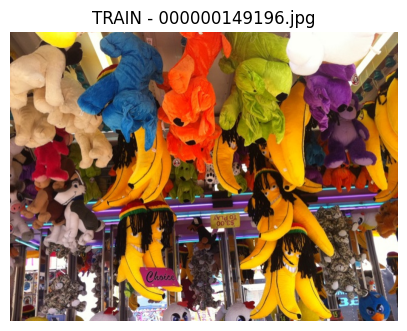


 Image: Sphynx_151_jpg.rf.b2ff269a98b5c2c9792d232d0060399c.jpg
Label: Sphynx_151_jpg.rf.b2ff269a98b5c2c9792d232d0060399c.txt
Label Content:
0 0.578125 0.5132211538461539 0.7475961538461539 0.96875


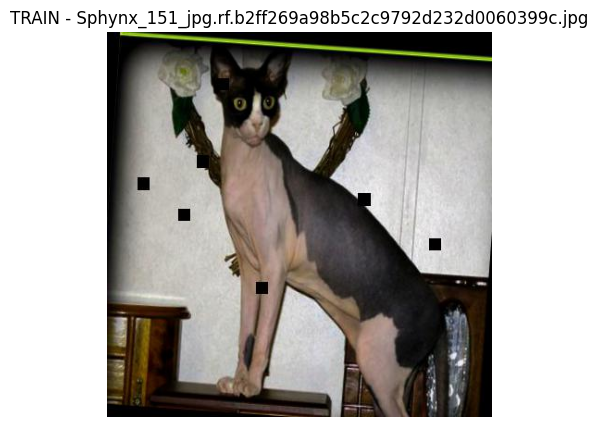


 Image: Maine_Coon_196_jpg.rf.831621635b0631dc644c5a2e6a38ead1.jpg
Label: Maine_Coon_196_jpg.rf.831621635b0631dc644c5a2e6a38ead1.txt
Label Content:
0 0.42908653846153844 0.5036057692307693 0.8581730769230769 0.9879807692307693


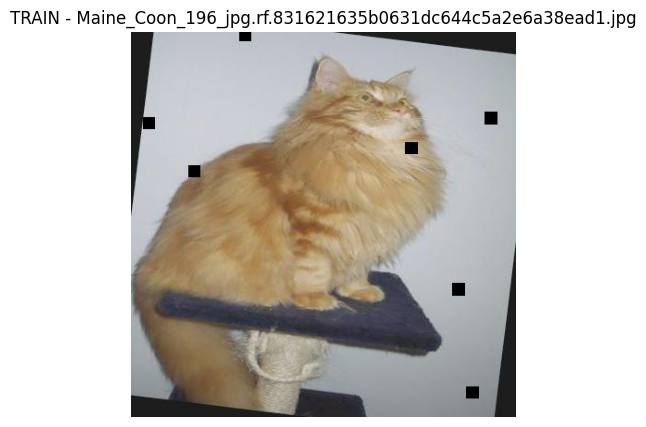


 Image: 000000523484.jpg
Label: 000000523484.txt
Label Content:
0 0.30004 0.7530399999999999 0.26039999999999996 0.15978666666666666
0 0.505 0.44625333333333334 0.14208 0.11933333333333333


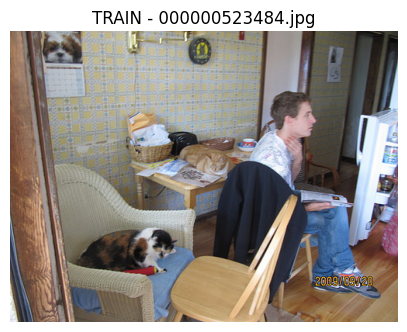


 Image: 000000208984.jpg
Label: 000000208984.txt
Label Content:
[Empty - no object]


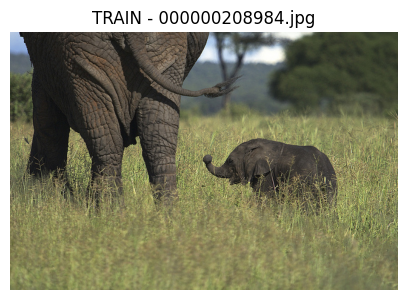


 Image: 000000306630.jpg
Label: 000000306630.txt
Label Content:
0 0.5104843750000001 0.4569895833333334 0.1241875 0.30752083333333335


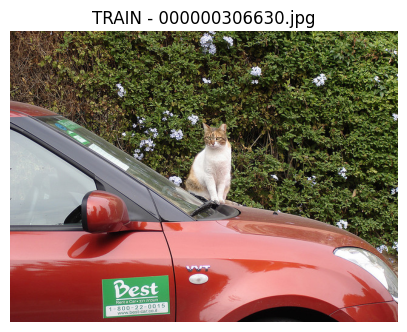


 Image: 000000042481.jpg
Label: 000000042481.txt
Label Content:
[Empty - no object]


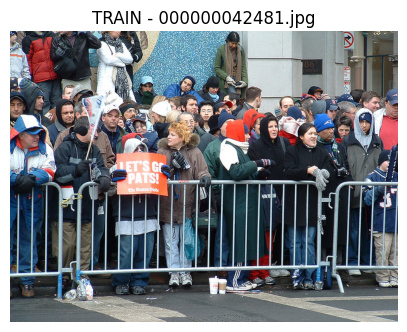


 Image: 000000313653.jpg
Label: 000000313653.txt
Label Content:
[Empty - no object]


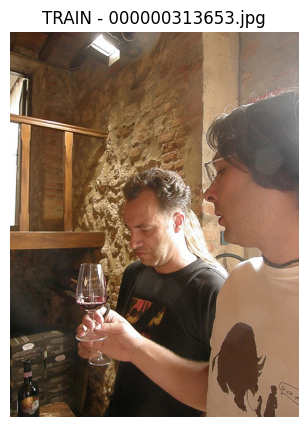


 Image: Persian_213_jpg.rf.09890fd29c6fe198ad586d95e82d0165.jpg
Label: Persian_213_jpg.rf.09890fd29c6fe198ad586d95e82d0165.txt
Label Content:
0 0.4987980769230769 0.4987980769230769 0.9975961538461539 0.9975961538461539


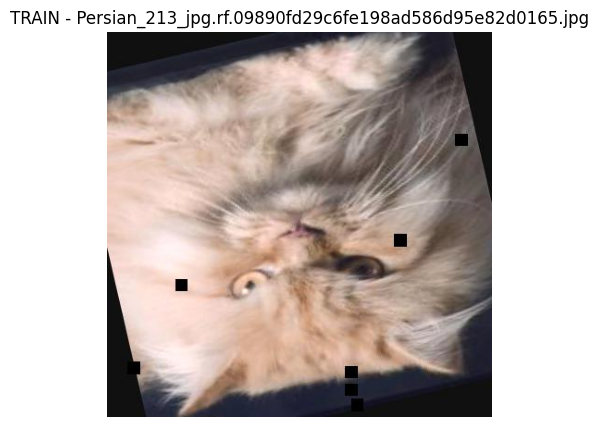


 Image: 000000243574.jpg
Label: 000000243574.txt
Label Content:
0 0.31687 0.6494976635514019 0.6293 0.7010046728971961
0 0.81547 0.6179789719626169 0.36906 0.6651635514018691


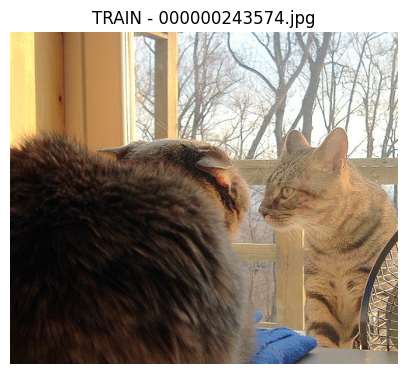


Previewing: VAL

 Image: 000000199822.jpg
Label: 000000199822.txt
Label Content:
0 0.4867265625 0.4694583333333334 0.6541718750000001 0.6701250000000001


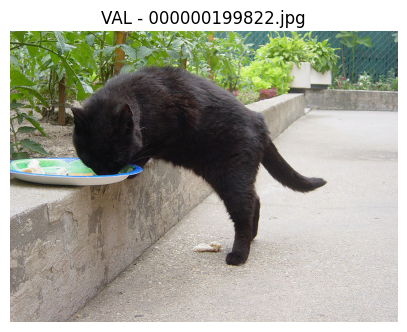


 Image: 000000082484.jpg
Label: 000000082484.txt
Label Content:
0 0.6577799999999999 0.731184971098266 0.48812 0.43011560693641615
0 0.31103 0.49569364161849716 0.42562 0.7591329479768787


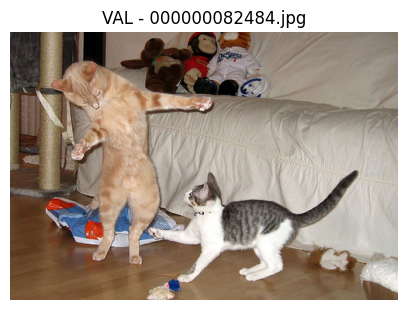


 Image: 000000117774.jpg
Label: 000000117774.txt
Label Content:
0 0.31618666666666667 0.67102 0.6215466666666667 0.65736


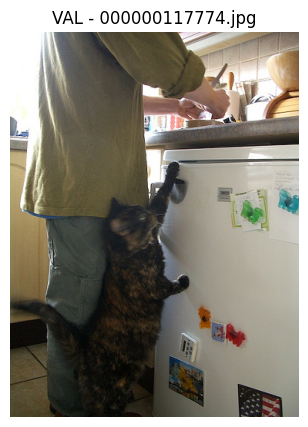


 Image: 000000048742.jpg
Label: 000000048742.txt
Label Content:
[Empty - no object]


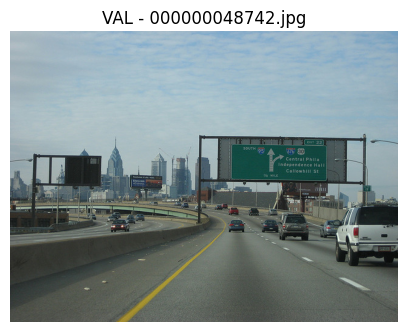


 Image: 000000408995.jpg
Label: 000000408995.txt
Label Content:
0 0.541109375 0.4901458333333333 0.18625 0.44741666666666663


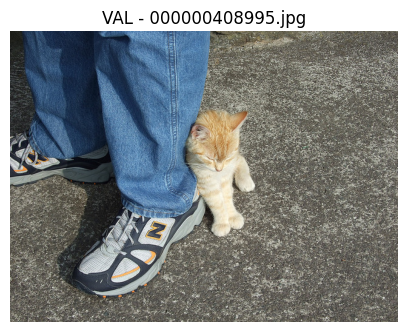


 Image: frame_0287.jpg
Label: frame_0287.txt
Label Content:
0 0.5616345405578613 0.6399328708648682 0.3987892270088196 0.7177652716636658


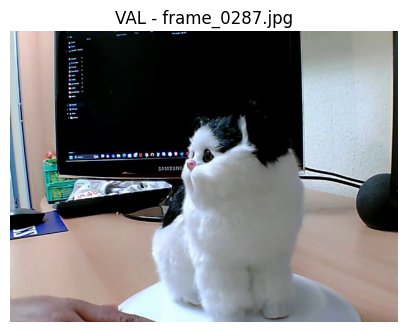


 Image: 000000311744.jpg
Label: 000000311744.txt
Label Content:
[Empty - no object]


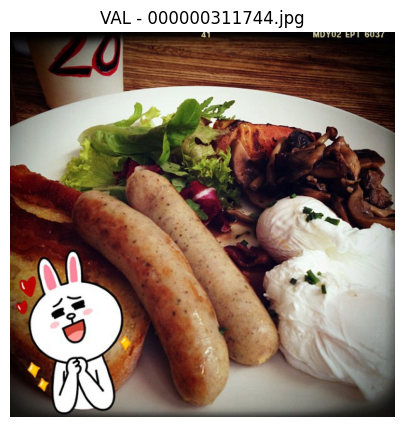


 Image: 000000054334.jpg
Label: 000000054334.txt
Label Content:
0 0.27590624999999996 0.6118896713615024 0.0401875 0.03950704225352112


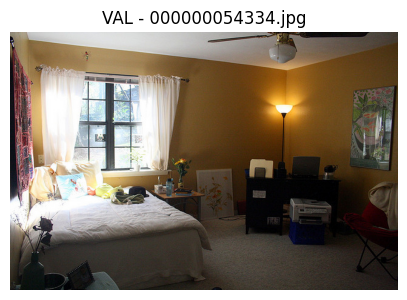


 Image: British_Shorthair_10_jpg.rf.f7d95d0eb4b18eaeb6e6fee78809766a.jpg
Label: British_Shorthair_10_jpg.rf.f7d95d0eb4b18eaeb6e6fee78809766a.txt
Label Content:
0 0.5060096153846154 0.5108173076923077 0.9831730769230769 0.9735576923076923


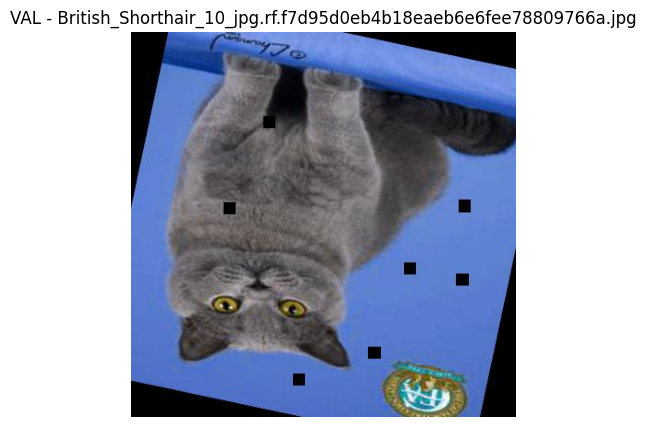


 Image: 000000042421.jpg
Label: 000000042421.txt
Label Content:
0 0.8504683840749415 0.722609375 0.29906323185011713 0.20090625


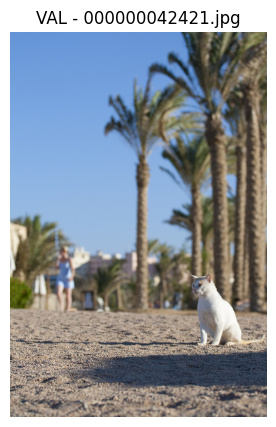

In [15]:
def preview_images_and_labels_with_display(img_dir, lbl_dir, image_files, title="Set"):
    print(f"\nPreviewing: {title}")

    sample_images = random.sample(image_files, min(10, len(image_files)))
    # COCO image names are 12-digit numbers like '000000569310.jpg'
    def is_coco_filename(name):
        base = os.path.basename(name).replace(".jpg", "")
        return base.isdigit() and len(base) == 12

    # Filter only COCO images
    coco_sample_images = [name for name in sample_images if is_coco_filename(name)]

    # Extract image IDs from COCO-style names
    image_ids = [int(name.replace(".jpg", "")) for name in coco_sample_images]


    for img_name in sample_images:
        label_name = img_name.replace(".jpg", ".txt")
        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(lbl_dir, label_name)

        print(f"\n Image: {img_name}")
        print(f"Label: {label_name}")

        if os.path.exists(lbl_path):
            with open(lbl_path, "r") as f:
                content = f.read().strip()
            print(f"Label Content:\n{content if content else '[Empty - no object]'}")
        else:
            print("Label file not found!")

        # Display the image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title(f"{title} - {img_name}")
        plt.axis('off')
        plt.show()

    return image_ids
# Set your paths
train_img_dir = os.path.join(output_dir, "images", "train")
val_img_dir   = os.path.join(output_dir, "images", "val")
train_lbl_dir = os.path.join(output_dir, "labels", "train")
val_lbl_dir   = os.path.join(output_dir, "labels", "val")

# Only need basename since images were moved
train_image_names = [os.path.basename(p) for p in train_images]
val_image_names = [os.path.basename(p) for p in val_images]


image_ids=preview_images_and_labels_with_display(train_img_dir, train_lbl_dir, train_image_names, title="TRAIN")
image_ids=preview_images_and_labels_with_display(val_img_dir, val_lbl_dir, val_image_names, title="VAL")

